# Pixel-based clustering

In this tutorial we will focus on pixel-based clustering. This tutorial assumes, that you have already registered and
pre-processed your data.


In [1]:
import numpy as np
import seaborn as sns
from skimage.transform import downscale_local_mean

import spatiomic as so

In [2]:
# read the example data
img_data = so.data.read().read_tiff("./data/example.tiff")
img_data = (downscale_local_mean(img_data, (4, 4, 1)) + 1 > 0).astype(float) * 255

Let's take a look at the data:


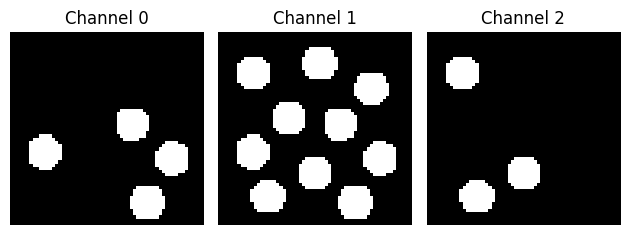

In [3]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3)

for i in range(3):
    ax[i].imshow(img_data[:, :, i], cmap="gray")
    ax[i].set_title("Channel {}".format(i))
    ax[i].axis("off")

plt.tight_layout()

## SOM training


First, we create our self-organizing map. The node count should scale with the size of your dataset and the complexity of your data. It is advisable to use the `euclidean`, `cosine` or `correlation` (Pearson correlation) distance metric for biological data.


In [4]:
som = so.dimension.som(
    node_count=(30, 30),
    dimension_count=img_data.shape[-1],
    distance_metric="euclidean",
    use_gpu=False,
    seed=42,
)

Next, we train our SOM on the data. Depending on the size of the data and the node count, this may take a while. To speed training up, consider training on a random subsample of your data. This can be achieved via `pp.data.subsample(data, method="fraction", fraction=0.1)` or `pp.data.subsample(data, method="count", count=10^9)`.


In [5]:
img_data_subsample = so.data.subsample().fit_transform(img_data, method="fraction", fraction=0.5, seed=42)

In [6]:
som.fit(img_data_subsample, iteration_count=100)

/Users/au734063/Documents/spatiomic/.venv/lib/python3.12/site-packages/xpysom/xpysom.py:425: RuntimeWarning: divide by zero encountered in divide
  self._numerator_gpu / self._denominator_gpu,
/Users/au734063/Documents/spatiomic/.venv/lib/python3.12/site-packages/xpysom/xpysom.py:425: RuntimeWarning: invalid value encountered in divide
  self._numerator_gpu / self._denominator_gpu,


## Graph clustering


After our self-organising map finishes training, we can use its nodes that now represent the topography of our dataset to create a kNN graph. Finally, we perform Leiden graph clustering.


In [7]:
knn_graph = so.neighbor.knn_graph().create(som, neighbor_count=100, distance_metric="euclidean", use_gpu=False)
clusters, modularity = so.cluster.leiden().predict(
    knn_graph, resolution=0.5, seed=42, use_gpu=False, iteration_count=10
)

## Plotting & evaluation


Now that we have identified clusters for each SOM node, we can use our SOM class to assign the cluster label of the closest SOM node to each pixel in the original data.


In [8]:
labelled_data = som.label(img_data, clusters, save_path="./data/example_labelled.npy")

We can use the `plot` submodule to visualize the data:


/var/folders/vg/vt1jjh256dn1g4sd6pknwxbs_qmnws/T/ipykernel_61881/2329922638.py:1: UserWarning: The glasbey color palette is part of colorcet and distributed under the Creative Commons Attribution 4.0 International Public License (CC-BY).
  colormap = so.plot.colormap(color_count=np.array(clusters).max() + 1, flavor="glasbey")


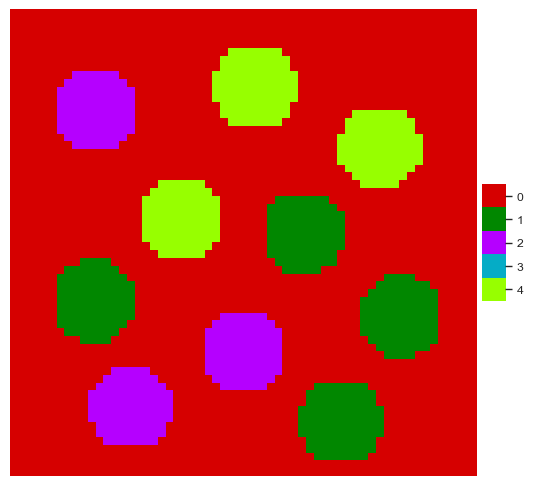

In [9]:
colormap = so.plot.colormap(color_count=np.array(clusters).max() + 1, flavor="glasbey")

fig = so.plot.cluster_image(
    labelled_data,
    colormap=colormap,
)

We can also plot the locations of individual clusters:


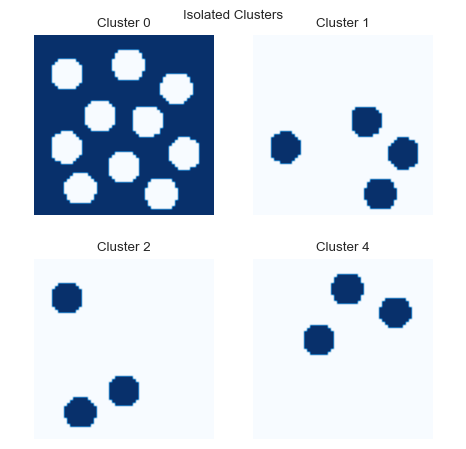

In [10]:
fig = so.plot.cluster_location(labelled_data)
fig.set_size_inches(5, 5)
fig.tight_layout(pad=2)

We can further evaluate how distributed the clusters are by calculating Moran's I.


In [11]:
df_morans_i = so.spatial.autocorrelation().predict(labelled_data, method="moran", permutation_count=500)

Calculating spatial autocorrelation for each channel/cluster: 100%|██████████| 4/4 [00:00<00:00, 24.69it/s]


In [12]:
df_morans_i

,cluster,morans_i,morans_i_expected,p_value,z_score
0,0,0.810741,-0.000278,0.001996,100.076246
1,1,0.841830,-0.000278,0.001996,96.222970
2,2,0.846760,-0.000278,0.001996,108.678817
3,4,0.846887,-0.000278,0.001996,94.977202


To evaluate the correlation of the clusters with the channels in the original image, we can use the bivariate version of Moran's I.


In [13]:
df_bv_morans_i = so.spatial.bivariate_correlation().predict(
    data=labelled_data,
    channel_image=img_data,
    method="moran",
)

An easy way to look at this data is by using the heatmap functionality from `seaborn`.


<Axes: xlabel='channel', ylabel='cluster'>

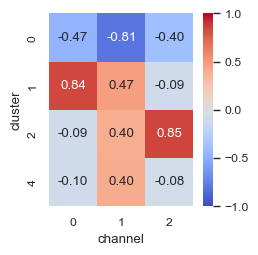

In [14]:
fig, ax = plt.subplots(dpi=100, figsize=(2.5, 2.5))
sns.heatmap(
    df_bv_morans_i.pivot(index="cluster", columns="channel", values="morans_i"),
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    annot=True,
    fmt=".2f",
    square=True,
    ax=ax,
)

## Statistics


We can also get the counts for each cluster in our image.


In [15]:
df_cluster_abundances = so.tool.count_clusters(
    file_paths=["./data/example_labelled.npy"],
    cluster_count=labelled_data.max() + 1,
)

<Axes: ylabel='file_path'>

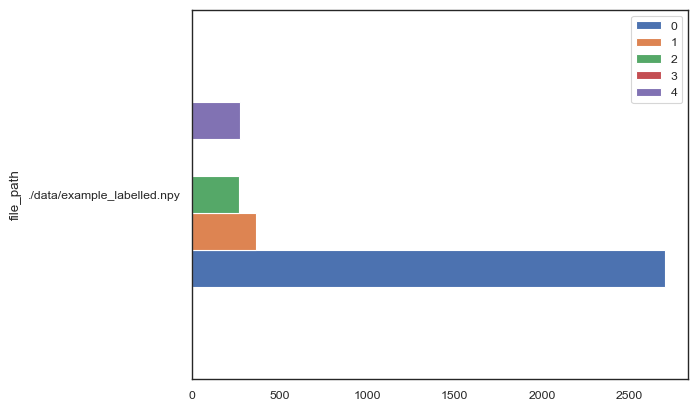

In [16]:
df_cluster_abundances.plot.barh()